
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **TFM - Análisis de sentimiento pólitico en Twitter**
### <p style="text-align:center"> **4. Otros Modelos**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 1. EDA y Selección/Preparación de variables
 2. Word Cloud y Análisis de viralidad
 3. Predicciones con GPT3
 4. <font color='darkgreen'> **Otros Modelos**</font>

Este cuaderno se enfoca 

  **INDICE:**
 
 - [Importación de Librerias](#0)
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Vectorización y división entre train y test](#3)

  **Modelos:**
 - [SVM](#4)
 - [Naive Bayes](#5) 
 - [XGBoost Classifier](#6)
 - [RandomForest](#7)
 - [Logistic Regression](#8)
 - [Comparativo](#9)
 - [Random Forest Fine Tunning](#10)
 - [Logistic Regression Fine Tunning](#11)
 

##  <a name="0"> Importación de Librerias</a>

In [1]:
from getpass import getpass
import openai
import requests
from PIL import Image
from io import BytesIO
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn import metrics 
import pickle
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

##  <a name="0"> Funciones utilizadas en este notebook</a>

In [2]:
def plot_roc_curves(y_test, y_scores, model_name):
    sentimientos_numericos = {'Positivo': 1, 'Negativo': -1, 'Neutro': 0}
    y_test_bin = label_binarize(y_test, classes=list(sentimientos_numericos.values()))
    n_classes = y_test_bin.shape[1]

    # Calcular ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la media micro de las métricas ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Dibujar las Curvas ROC
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='Media micro ROC (área = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC de la clase {0} (área = {1:0.2f})'
                 ''.format(list(sentimientos_numericos.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC para multi-clases ({})'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

In [3]:
def print_classification_report(y_test, predictions, model_name):
    report = classification_report(y_test, predictions, labels=[1, -1, 0], 
                                   target_names=['Positivo', 'Negativo', 'Neutro'])
    f2_score = fbeta_score(y_test, predictions, beta=2, average='weighted')
    
    print(f'Model: {model_name}')
    print(report)
    print(f'F2 Score: {f2_score:.2f}')
    print('\n')

In [4]:
def print_model_metrics(models, model_names, X_test, y_test):
    for model, model_name in zip(models, model_names):
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='weighted')
        f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')

        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"F2-Score: {f2:.4f}")
        print()

##  <a name="2"> Carga de datos</a>

In [5]:
file_path = '../data/processed/df_sentimiento_final.csv'
df = pd.read_csv(file_path)
df = df.drop("Unnamed: 0", axis=1)
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños,Num_words_POST,sentimiento_clean
0,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...","comenzamos la campana, una vez mas, junto a la...",positive,2,...,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,71,42,comenzamos campana vez mas junto agricultura c...
1,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...","madrid es la region del espiritu de ermua, la ...",negative,0,...,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70,24,madrid region espiritu ermua admite totalitari...
2,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...","majadahonda con ganas de libertad, familia, un...",positive,2,...,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70,17,majadahonda ganas libertad familia unidad aleg...
3,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente: libranos del mal.,positive,2,...,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70,4,presidente libranos mal
4,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,En Madrid sólo habrá 2 tarifas de transporte p...,en madrid solo habra 2 tarifas de transporte p...,negative,0,...,0.001445,759,0.003562,3016,0.014153,1586985,0.4734,70,51,madrid solo habra 2 tarifas transporte publico...


In [6]:
# Seleccionar la fila que contiene el valor nulo en la columna "sentimiento_clean"
fila_nula = df.loc[df['sentimiento_clean'].isnull()]

# Mostrar la fila nula
print(fila_nula)

   partido  partido_num         candidato           nick  followers  \
96    vox             1  Rocío Monasterio   @monasterioR     339700   

         fecha           post     post_clean sentimiento  sentimiento_num  \
96  2023-05-23  ¿Y tú cuándo?  ?y tu cuando?     neutral                1   

    ...  comments vs viewed  shared  shared vs viewed  likes  likes vs viewed  \
96  ...            0.002295     351          0.007389    884         0.018611   

     votos  porcentaje  escaños  Num_words_POST  sentimiento_clean  
96  245215      0.0731       11               3                NaN  

[1 rows x 29 columns]


In [7]:
df = df.drop(96)

##  <a name="3"> Vectorización y división entre train y test</a>

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['sentimiento_clean'])
y = df['sentimiento_num']  

In [9]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##  <a name="4"> SVM</a>

In [10]:
# Entrenar un modelo SVM
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, svm_classifier)
svm_predictions = svm_classifier.predict(X_test)

In [11]:
print_classification_report(y_test, svm_predictions, 'SVM')

Model: SVM
              precision    recall  f1-score   support

    Positivo       1.00      0.07      0.12        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.62      0.94      0.75        77

   micro avg       0.62      0.79      0.70        92
   macro avg       0.54      0.33      0.29        92
weighted avg       0.68      0.79      0.64        92

F2 Score: 0.64




[[72  0  5]
 [12  1  2]
 [32  0 30]]


<Axes: >

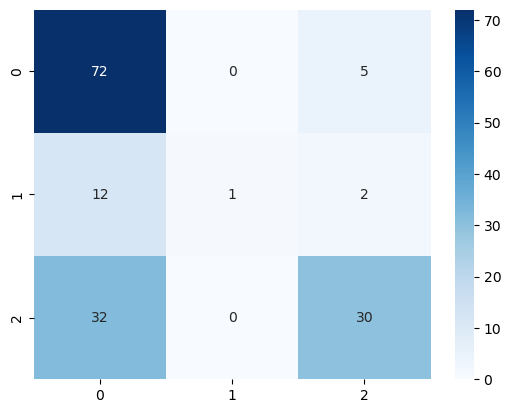

In [12]:
print(confusion_matrix(y_test,svm_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, svm_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [13]:
# Save the model.
pickle.dump(model, open('../models/svc_model_tweets_sent.pkl', 'wb'))

In [14]:
def plot_roc_curves(y_test, y_scores, model_name):
    sentimientos_numericos = {'Positivo': 1, 'Negativo': -1, 'Neutro': 0}
    y_test_bin = label_binarize(y_test, classes=list(sentimientos_numericos.values()))
    n_classes = y_test_bin.shape[1]

    # Calcular ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la media micro de las métricas ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Dibujar las Curvas ROC
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='Media micro ROC (área = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC de la clase {0} (área = {1:0.2f})'
                 ''.format(list(sentimientos_numericos.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC para multi-clases ({})'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

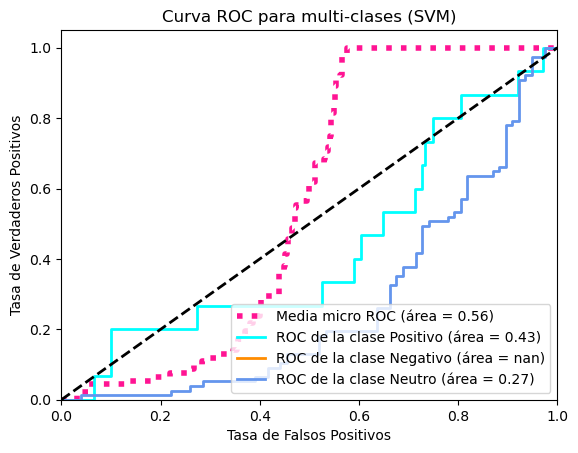

In [15]:
scores = svm_classifier.decision_function(X_test)
plot_roc_curves(y_test, scores, 'SVM')

##  <a name="5"> Naive Bayes</a>

In [16]:
# Entrenar un modelo Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, nb_classifier)
nb_predictions = nb_classifier.predict(X_test)

In [17]:
print_classification_report(y_test, nb_predictions, 'Naive Bayes')

Model: Naive Bayes
              precision    recall  f1-score   support

    Positivo       0.00      0.00      0.00        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.67      0.79      0.73        77

   micro avg       0.67      0.66      0.67        92
   macro avg       0.22      0.26      0.24        92
weighted avg       0.56      0.66      0.61        92

F2 Score: 0.67




[[61  0 16]
 [13  0  2]
 [17  0 45]]


<Axes: >

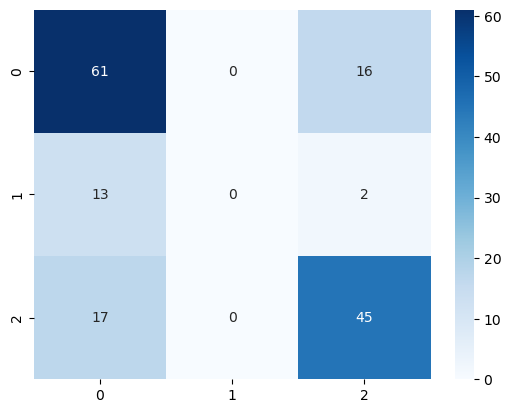

In [18]:
print(confusion_matrix(y_test,nb_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, nb_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [19]:
# Save the model.
pickle.dump(model, open('../models/nb_model_tweets_sent.pkl', 'wb'))

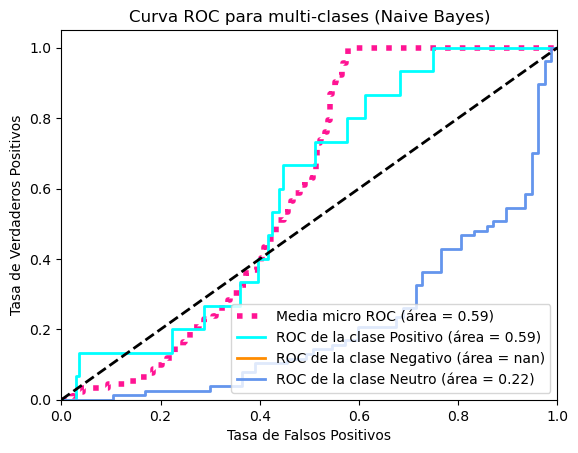

In [20]:
scores = nb_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Naive Bayes')

##  <a name="6"> XGBoost Classifier</a>

In [21]:
# Entrenar un modelo XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, xgb_classifier)
xgb_predictions = xgb_classifier.predict(X_test)

In [22]:
print_classification_report(y_test, xgb_predictions, 'XGBoost')

Model: XGBoost
              precision    recall  f1-score   support

    Positivo       0.40      0.40      0.40        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.69      0.79      0.73        77

   micro avg       0.64      0.73      0.68        92
   macro avg       0.36      0.40      0.38        92
weighted avg       0.64      0.73      0.68        92

F2 Score: 0.67




[[61  4 12]
 [ 7  6  2]
 [21  5 36]]


<Axes: >

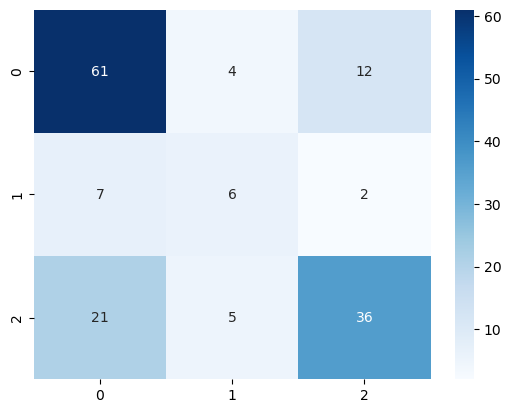

In [23]:
print(confusion_matrix(y_test,xgb_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, xgb_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [24]:
# Save the model.
pickle.dump(model, open('../models/xgb_model_tweets_sent.pkl', 'wb'))

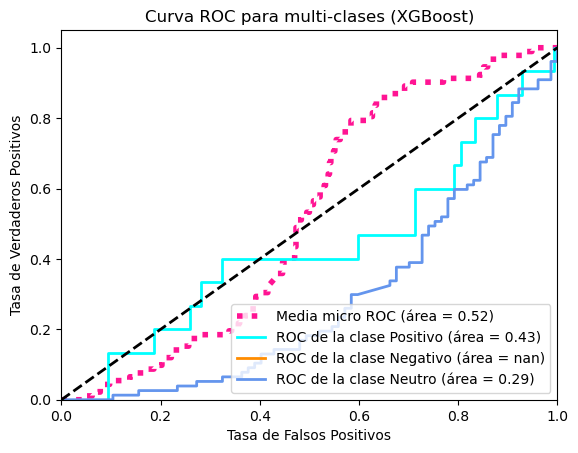

In [25]:
scores = xgb_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'XGBoost')

##  <a name="7"> Random Forest</a>

In [26]:
# Entrenar un modelo RandomForest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, rf_classifier)
rf_predictions = rf_classifier.predict(X_test)

In [27]:
print_classification_report(y_test, rf_predictions, 'Random Forest')

Model: Random Forest
              precision    recall  f1-score   support

    Positivo       0.60      0.20      0.30        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.65      0.84      0.73        77

   micro avg       0.65      0.74      0.69        92
   macro avg       0.42      0.35      0.34        92
weighted avg       0.64      0.74      0.66        92

F2 Score: 0.66




[[65  0 12]
 [10  3  2]
 [25  2 35]]


<Axes: >

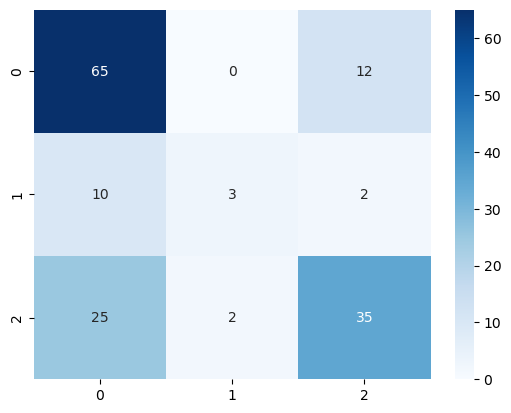

In [28]:
print(confusion_matrix(y_test,rf_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, rf_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [29]:
# Save the model.
pickle.dump(model, open('../models/rf_model_tweets_sent.pkl', 'wb'))

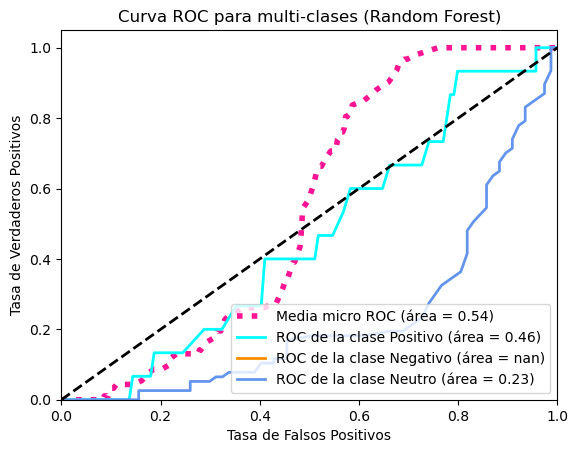

In [30]:
scores = rf_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Random Forest')

##  <a name="8"> Logistic Regression</a>

In [31]:
# Entrenar un modelo de Regresión Logística
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, lr_classifier)
lr_predictions = lr_classifier.predict(X_test)

In [32]:
print_classification_report(y_test, lr_predictions, 'Logistic Regresion')

Model: Logistic Regresion
              precision    recall  f1-score   support

    Positivo       0.00      0.00      0.00        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.65      0.86      0.74        77

   micro avg       0.65      0.72      0.68        92
   macro avg       0.22      0.29      0.25        92
weighted avg       0.55      0.72      0.62        92

F2 Score: 0.66




[[66  0 11]
 [12  0  3]
 [23  0 39]]


<Axes: >

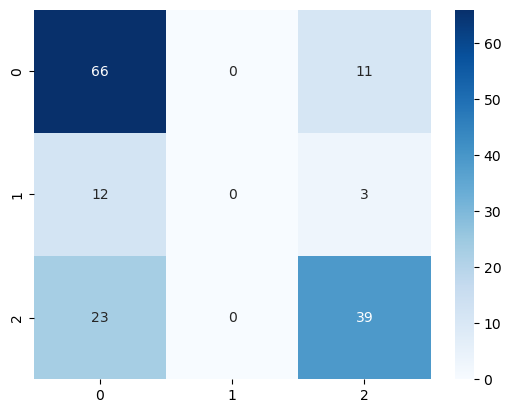

In [33]:
print(confusion_matrix(y_test,lr_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, lr_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [34]:
# Save the model.

pickle.dump(model, open('../models/lr_model_tweets_sent.pkl', 'wb'))

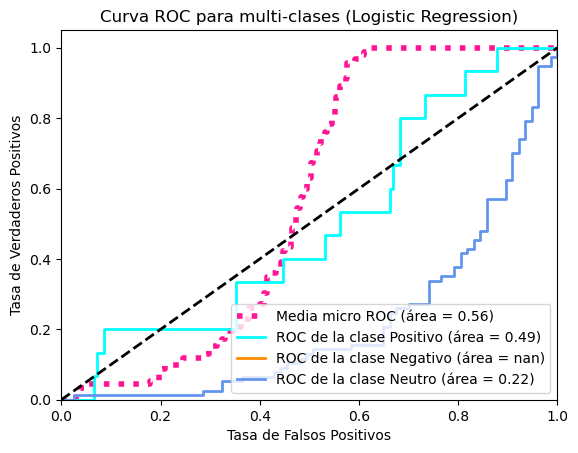

In [35]:
scores = lr_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Logistic Regression')

##  <a name="9"> Comparativo</a>

In [36]:
# Uso de la función con tus modelos y datos de prueba
models = [svm_classifier, nb_classifier, xgb_classifier, rf_classifier, lr_classifier]
model_names = ['SVM', 'Naive Bayes', 'XGBClassifier', 'RandomForest', 'Logistic Regression']
print_model_metrics(models, model_names, X_test, y_test)

Model: SVM
Accuracy: 0.6688
F1-Score: 0.6292
F2-Score: 0.6444

Model: Naive Bayes
Accuracy: 0.6883
F1-Score: 0.6530
F2-Score: 0.6735

Model: XGBClassifier
Accuracy: 0.6688
F1-Score: 0.6652
F2-Score: 0.6663

Model: RandomForest
Accuracy: 0.6688
F1-Score: 0.6503
F2-Score: 0.6580

Model: Logistic Regression
Accuracy: 0.6818
F1-Score: 0.6439
F2-Score: 0.6642



##  <a name="10"> Random Forest</a>

In [37]:
# Define los parámetros que quieres ajustar
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Crea una nueva instancia del modelo
rf_classifier = RandomForestClassifier()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid=params, cv=5)

# Ajusta los datos
grid_search.fit(X_train, y_train)

# Imprime los mejores parámetros
print("Best Parameters: ", grid_search.best_params_)

# Predice con los mejores parámetros
rf_predictions = grid_search.predict(X_test)

Best Parameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [38]:
print_classification_report(y_test, rf_predictions, 'Random Forest')

Model: Random Forest
              precision    recall  f1-score   support

    Positivo       0.67      0.13      0.22        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.73      0.83      0.78        77

   micro avg       0.73      0.72      0.72        92
   macro avg       0.46      0.32      0.33        92
weighted avg       0.72      0.72      0.69        92

F2 Score: 0.72




Model: Random Forest
Accuracy: 0.7273
F1-Score: 0.7058
F2-Score: 0.7172



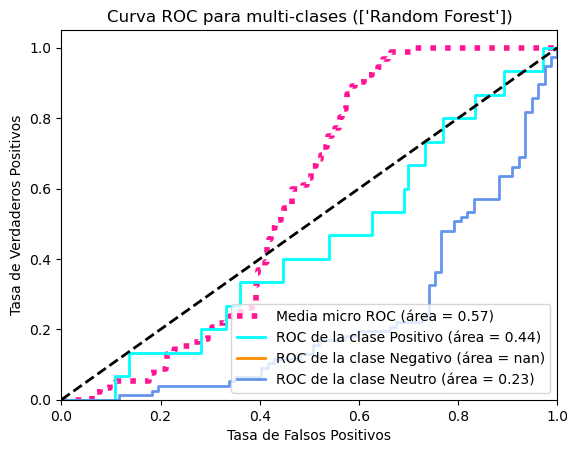

In [39]:
# Uso de la función con tus modelos y datos de prueba
models = [grid_search.best_estimator_]
model_names = ['Random Forest']
print_model_metrics(models, model_names, X_test, y_test)

# Para usar la función plot_roc_curves, necesitas las puntuaciones de confianza de tu modelo
y_scores = grid_search.predict_proba(X_test)

# Ahora puedes llamar a tu función
y_scores = grid_search.predict_proba(X_test)
# Ahora puedes llamar a tu función
plot_roc_curves(y_test, y_scores, model_names)

In [40]:
# Save the model.
pickle.dump(model, open('../models/xgb_model_tweets_sent_final.pkl', 'wb'))

[[64  0 13]
 [ 9  2  4]
 [15  1 46]]


<Axes: >

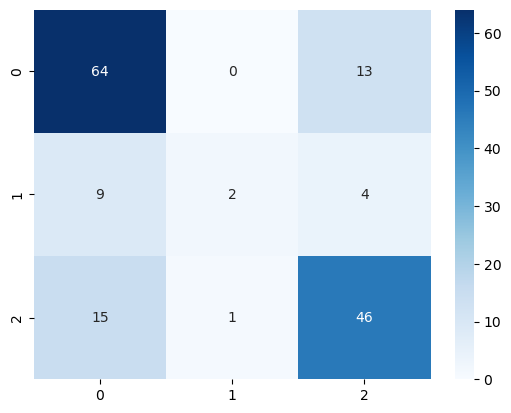

In [41]:
print(confusion_matrix(y_test,rf_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, rf_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

##  <a name="11"> Naive Bayes Fine Tunning</a>

In [42]:
# Define los parámetros que quieres ajustar
params = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False],
    'class_prior': [None, [0.2, 0.3, 0.2, 0.1, 0.2]],
}

# Crea una nueva instancia del modelo
nb_classifier = MultinomialNB()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid=params, cv=5)

# Ajusta los datos
grid_search.fit(X_train, y_train)

# Imprime los mejores parámetros
print("Best Parameters: ", grid_search.best_params_)

# Predice con los mejores parámetros
nb_predictions = grid_search.predict(X_test)

Best Parameters:  {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}


In [43]:
print_classification_report(y_test, nb_predictions, 'Naive Bayes')

Model: Naive Bayes
              precision    recall  f1-score   support

    Positivo       1.00      0.07      0.12        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.70      0.71      0.71        77

   micro avg       0.70      0.61      0.65        92
   macro avg       0.57      0.26      0.28        92
weighted avg       0.75      0.61      0.61        92

F2 Score: 0.67




Model: Naive Bayes
Accuracy: 0.6818
F1-Score: 0.6548
F2-Score: 0.6696



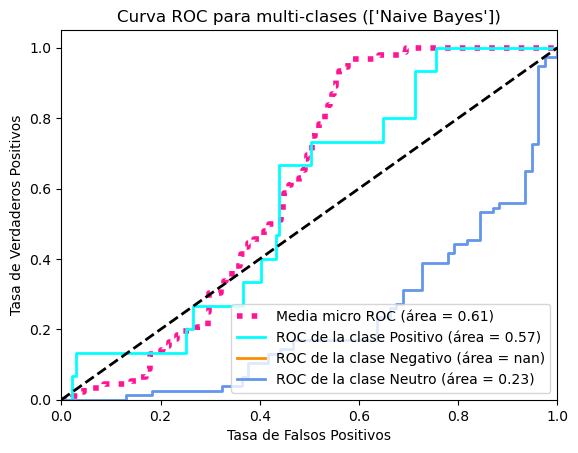

In [44]:
# Uso de la función con tus modelos y datos de prueba
models = [grid_search.best_estimator_]
model_names = ['Naive Bayes']
print_model_metrics(models, model_names, X_test, y_test)

# Para usar la función plot_roc_curves, necesitas las puntuaciones de confianza de tu modelo
y_scores_nb = grid_search.predict_proba(X_test)

# Ahora puedes llamar a tu función
plot_roc_curves(y_test, y_scores_nb, model_names)

In [45]:
# Guardar el modelo
pickle.dump(model, open('../models/lr_model_tweets_sent_final.pkl', 'wb'))

[[66  0 11]
 [12  0  3]
 [23  0 39]]


<Axes: >

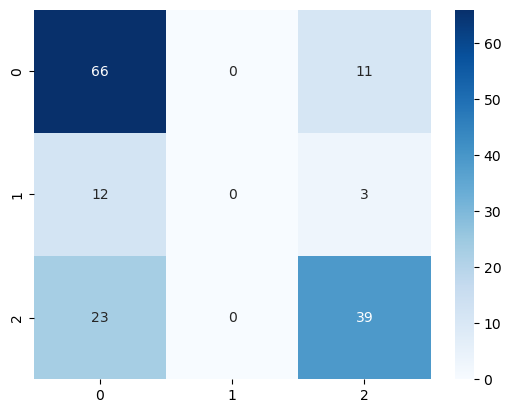

In [46]:
# Matriz de confusión
conf_mat = confusion_matrix(y_test, lr_predictions)
print(conf_mat)

# Plot de la matriz de confusión
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')